# How do you convert your images to Paintings in style of Monet?

This task is obviously for GAN. However in this case we are translating pictures
from one domain in to another and we don't have 1-1 images from one domain to the 
next. This means we'll need to use something called CycleGAN.


Here are a few documents I found useful in understanding CycleGANs:
https://developers.arcgis.com/python/latest/guide/how-cyclegan-works/
https://medium.com/imagescv/what-is-cyclegan-and-how-to-use-it-2bfc772e6195

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.


The original paper for CycleGan was a huge help. It can help even if you are not a math wizard:
https://arxiv.org/abs/1703.10593 "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks"

In [1]:
import tensorflow as tf
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
from tqdm import tqdm
from PIL import Image

from kaggle_datasets import KaggleDatasets

Setting up the random seeds for repruducibility

In [2]:
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

the main model parameters

In [3]:
batch_size = 1
img_size =  256

Getting the file directories

In [4]:
autotune = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()

#file directories of the tfrec files
monet_imgs_fnames = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_imgs_fnames = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))


In [5]:

def read_tfr(example):
    
    """
    function to read the TFrecords files, as can be seen
    at the end only the image is returned leaving behind the label and te name
    """
    
    feature_map = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
        }
    
    example = tf.io.parse_single_example(example, feature_map)
    
    image = tf.io.decode_jpeg(example['image'])
    image = tf.image.resize(image, (256,256))
    
    image = image / 127.5 - 1
    
    
    return image



def load_ds(filenames, aug):
    
    tfrecords = tf.data.TFRecordDataset(filenames)
    tfrecords = tfrecords.map(read_tfr, num_parallel_calls = autotune)
    if aug:
        tfrecords = tfrecords.map(augment, num_parallel_calls = autotune)
    return tfrecords


def get_ds(filenames, aug = True):
    
    
    ds = load_ds(filenames, aug)
    ds = ds.shuffle(2048)
    ds = ds.batch(batch_size) #setting the dataset in batches
    ds = ds.prefetch(autotune) # prefetch is used to improve performance
    return ds

def augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_adjust_brightness = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    image = tf.image.resize(image, (286,286))
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    if p_adjust_brightness > .9:
        image = tf.image.adjust_brightness(image, 0.12)
    elif p_adjust_brightness > .7:
        image = tf.image.adjust_brightness(image, 0.08)
    elif p_adjust_brightness > .5:
        image = tf.image.adjust_brightness(image, 0.05)
    
    image = tf.image.random_crop(image, [256,256,3])
    
    
    return image

In [6]:
monet_ds = get_ds(monet_imgs_fnames)
photo_ds = get_ds(photo_imgs_fnames)

Getting 5 examples from each dataset, the photo dataset and the monet Dataset

In [7]:
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

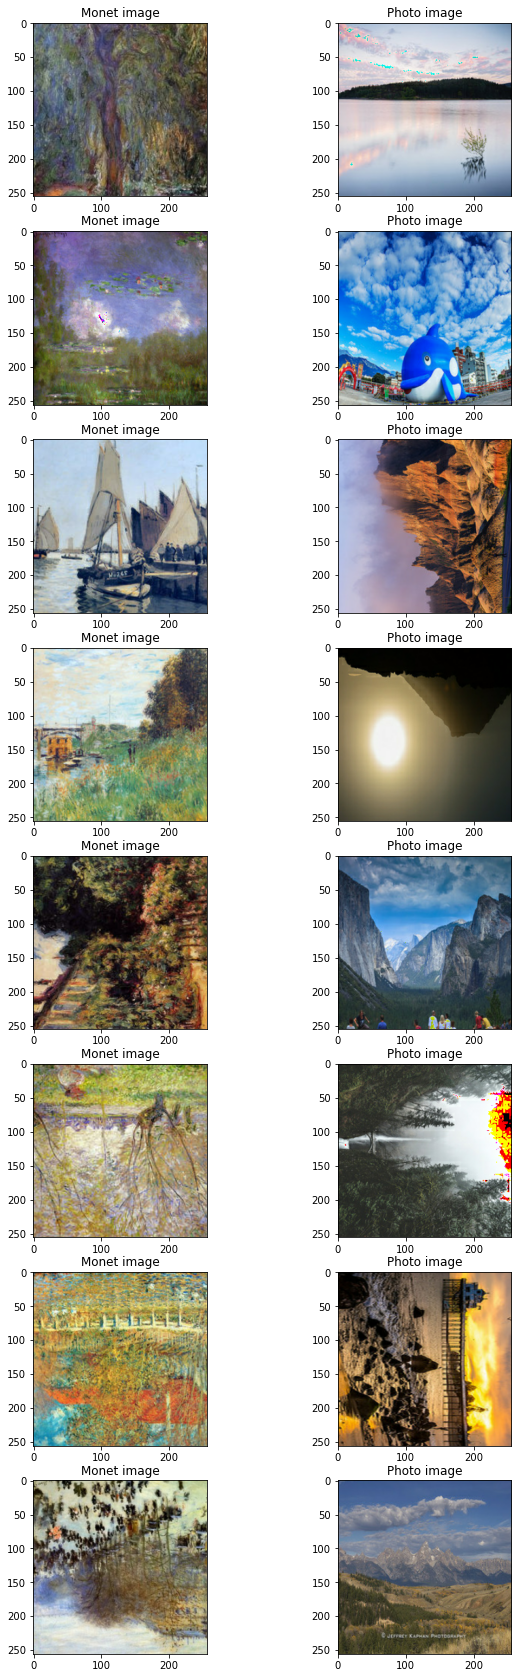

In [8]:
_ = plt.figure(figsize=(10,30))

for i in range(5):

    plt.subplot(8,2,i*2 +1)
    plt.imshow(tf.cast(next(monet_iter)[0] * 127.5 + 127.5, tf.uint8))
    plt.title("Monet image")

    plt.subplot(8,2,i*2 +2)
    plt.imshow(tf.cast(next(photo_iter)[0] * 127.5 + 127.5, tf.uint8))
    plt.title("Photo image")

The following block of code will be creating the upsample and downsample blocks of the modified Unet (the cycle gan model is based on the Unet model)

In [9]:
# starting with the generator model

def downsample(filters, size, apply_batchnorm = True):
    
    
    
    initializer = tf.random_normal_initializer()

        # the use of sequential is preferred to make the code simpler

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters,
                                         size,
                                         strides = 2,
                                         padding = 'same',
                                         kernel_initializer = initializer,
                                         use_bias = False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout = False):
    
   
    
    initialzer = tf.random_normal_initializer()

    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2DTranspose(filters,
                                                  size,
                                                  strides = 2,
                                                  padding = 'same',
                                                  kernel_initializer = initialzer,
                                                  use_bias = False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

Generator model, which is the unet, the use of the blocks previousled created can be seen here.

In [10]:
def create_generator():
    

    
    inputs = tf.keras.Input(shape = (256,256,3,))

    down_stack = [
            downsample(64,4, apply_batchnorm= False),
            downsample(128,4),
            downsample(256,4),
            downsample(512,4),
            downsample(512,4),
            downsample(512,4),
            downsample(512,4),
            downsample(512,4)
        ]

    up_stack = [
            upsample(512, 4, apply_dropout= True),
            upsample(512, 4, apply_dropout= True),
            upsample(512, 4, apply_dropout= True),
            upsample(512, 4),
            upsample(512, 4),
            upsample(256, 4),
            upsample(128, 4),
            upsample(64, 4)
        ]


    initializer = tf.random_normal_initializer()

    x = inputs

        #downsampling stage

    skips = [] #skips used to concatenate with the model in the upsampling stage

    for down in down_stack:

        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):

        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])

    x = tf.keras.layers.Conv2DTranspose(3, 4, strides = 2,
                                           padding = 'same',
                                           kernel_initializer = initializer, activation = 'tanh')(x)

    return tf.keras.models.Model(inputs = inputs, outputs = x)


In [11]:
generator_monet = create_generator()
generator_photo = create_generator()
generator_monet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
_______________________________________________________________________________________

(-0.5, 255.5, 255.5, -0.5)

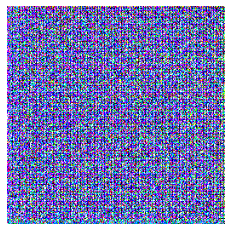

In [12]:
# picture generated from the random weights of the generator
random_img = generator_monet(next(photo_iter) *127.5 + 127.5)
random_img = random_img[0]
plt.imshow(random_img)
plt.axis('off')

The discriminator model is a PatchGan which is basically a regular discriminator that is more speficific tor parts of the photo rather than overall

In [13]:
# building the discriminator model which is a PatchGan

def create_discriminator():
    
    
    initializer = tf.random_normal_initializer()

    x = tf.keras.Input(shape = (256, 256, 3,))


    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)

    conv = tf.keras.layers.Conv2D(512, 4, strides = 1,
                                     kernel_initializer = initializer,
                                     use_bias = False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    outputs = tf.keras.layers.Conv2D(1,4, strides = 1,
                                        kernel_initializer = initializer)(zero_pad2)

    return tf.keras.Model(inputs = x, outputs = outputs)


In [14]:
discriminator_monet = create_discriminator()
discriminator_photo = create_discriminator()
discriminator_monet.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_33 (Sequential)   (None, 64, 64, 128)       131584    
_________________________________________________________________
sequential_34 (Sequential)   (None, 32, 32, 256)       525312    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
batch_normalization_32 (Batc (None, 31, 31, 512)      

In [16]:
# defining the losses of the models 

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True) # the from logits argument is very important since the 
#discriminator model will return a grid of probabilities 

def discriminator_loss(real_image, generated):
    
    """
    The loss of the discriminator is simple, just compare two inputs of the same label
    one is synthetic and the other one is real
    """

    real_loss = loss_object(tf.ones_like(real_image), real_image)
    generated_loss = loss_object(tf.zeros_like(generated), generated)

    total_loss = real_loss + generated_loss

    return total_loss

def generator_loss(generated):
    
    """
    The generator loss is also simple, basically does better when the discriminator does worse, this is the 
    adversarial component of the model
    """

    gen_loss = loss_object(tf.ones_like(generated), generated)

    return gen_loss

def consistency_loss(original, returned, LAMBDA):
    
    """
    this is also known as the cycle loss
    """
    
    loss = tf.reduce_mean(tf.abs(original-returned))
    
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA):
    
    """
    this function helps color preservation on the output of the generators
    """
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * LAMBDA * loss

One optimizer of each model

In [17]:
gm_gen_opt = tf.keras.optimizers.Adam(2e-4)
p_gen_opt = tf.keras.optimizers.Adam(2e-4)
m_disc_opt = tf.keras.optimizers.Adam(2e-4)
p_disc_opt = tf.keras.optimizers.Adam(2e-4)


In [18]:
def train_step(photo, monet):
    
    with tf.GradientTape() as monet_gen_tape, tf.GradientTape() as monet_disc_tape, tf.GradientTape() as photo_gen_tape, tf.GradientTape() as photo_disc_tape:

            #monet generator
        fake_monet = generator_monet(photo, training =True)
        cycled_photo = generator_photo(fake_monet, training = True)
            
            #photo generator
            
        fake_photo = generator_photo(monet, training = True)
        cycled_monet = generator_monet(fake_photo, training = True)
            
            #monet discriminator 
            
        fake_monet_disc = discriminator_monet(fake_monet, training = True)
        real_monet_disc = discriminator_monet(monet, training = True)
            
            #photo discriminator
            
        fake_photo_disc = discriminator_photo(fake_photo, training = True)
        real_photo_disc = discriminator_photo(photo, training = True)
        
            # for identity loss
        same_monet = generator_monet(monet, training = True)
        same_photo = generator_photo(photo, training = True)
            
            
            #generator loss
        monet_gen_loss = generator_loss(fake_monet_disc)
        photo_gen_loss = generator_loss(fake_photo_disc)
            
            #discrimintor loss
            
        monet_disc_loss = discriminator_loss(real_monet_disc, fake_monet_disc)
        photo_disc_loss = discriminator_loss(real_photo_disc, fake_photo_disc)
            
            #consistency/cycle loss
            
        monet_cycle_loss = consistency_loss(monet, cycled_monet, 0.25)
        photo_cycle_loss = consistency_loss(photo, cycled_photo, 0.25)
        total_cycle_loss = monet_cycle_loss + photo_cycle_loss
        
            #identity loss
            
        monet_id_loss = identity_loss(monet, same_monet, 0.25)
        photo_id_loss = identity_loss(photo, same_photo, 0.25)
            
            
            #generator total losses
            
        monet_generator_total_loss = monet_gen_loss + total_cycle_loss + monet_id_loss
        photo_generator_total_loss = photo_gen_loss + total_cycle_loss + photo_id_loss
            

    monet_generator_gradients = monet_gen_tape.gradient(monet_generator_total_loss, generator_monet.trainable_variables)
    photo_generator_gradients = photo_gen_tape.gradient(photo_generator_total_loss, generator_photo.trainable_variables)
        
    monet_discriminator_gradients = monet_disc_tape.gradient(monet_disc_loss, discriminator_monet.trainable_variables)
    photo_discriminator_gradients = photo_disc_tape.gradient(photo_disc_loss, discriminator_photo.trainable_variables)

    gm_gen_opt.apply_gradients(zip(monet_generator_gradients, generator_monet.trainable_variables))
    p_gen_opt.apply_gradients(zip(photo_generator_gradients, generator_photo.trainable_variables))
        
    m_disc_opt.apply_gradients(zip(monet_discriminator_gradients, discriminator_monet.trainable_variables))
    p_disc_opt.apply_gradients(zip(photo_discriminator_gradients, discriminator_photo.trainable_variables))

In [19]:
def show_progress():
    
    """
    function that takes 4 examples of each sample dataset to show its progress while training
    """

    photo_iter = iter(photo_ds)
        
    _ = plt.figure(figsize = (15,5))
        
    for i in range(4):
        
        fake_monets = generator_monet(next(photo_iter))[0]
            
        plt.subplot(1,4, i+1)
        plt.imshow(tf.cast(fake_monets * 127.5 + 127.5, tf.uint8))
        plt.title("monet generator")
            
    plt.show()

def fit(monets, photos, epochs):

    for epoch in range(epochs):

        show_progress()

    # this is the actual training bit

        for mon, pho in tqdm(zip(monets, photos)):

            train_step(pho, mon)

### Plot the model

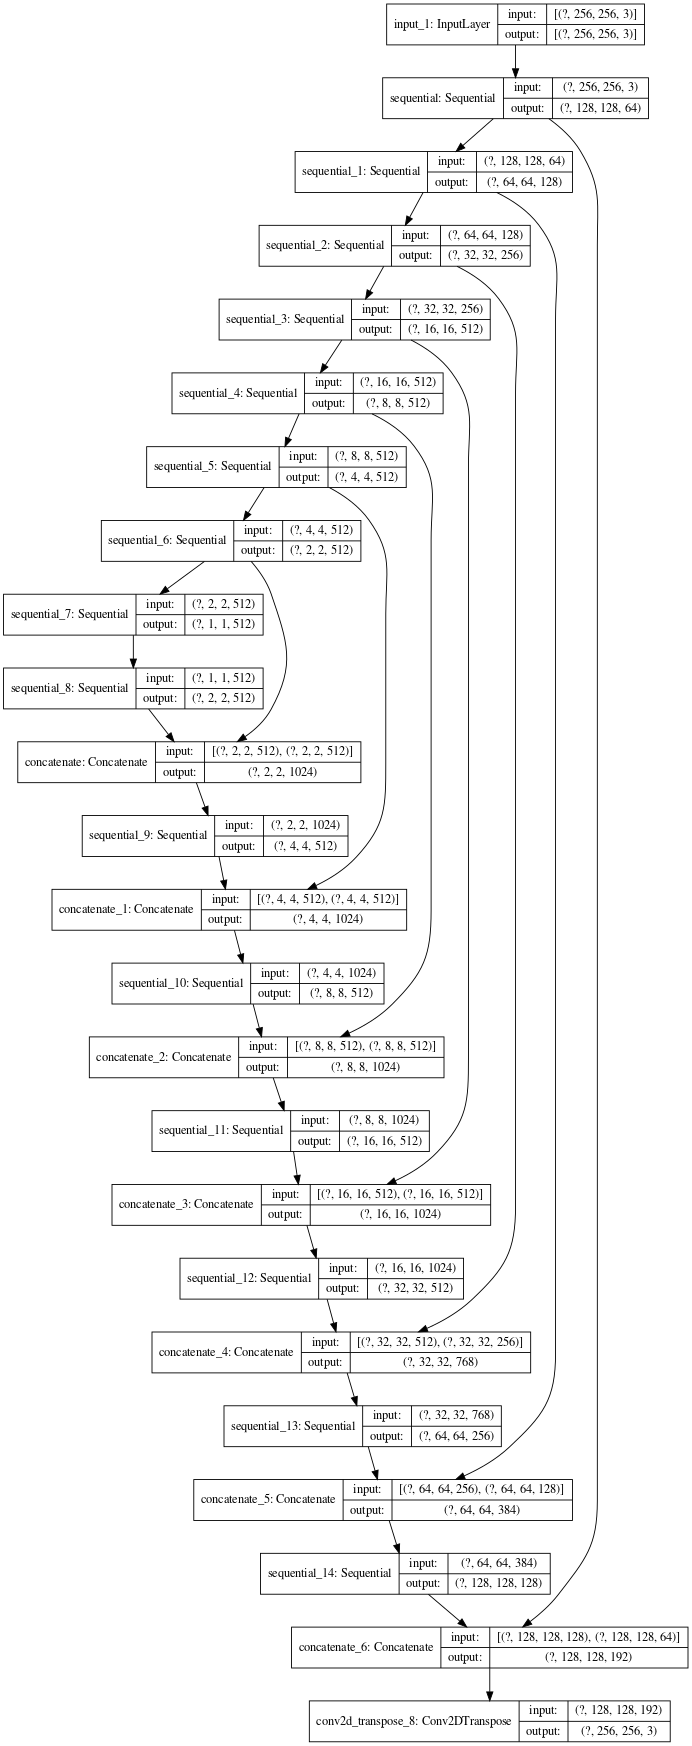

In [27]:
tf.keras.utils.plot_model(generator_monet, show_shapes=True, dpi=64, to_file="generator.png")


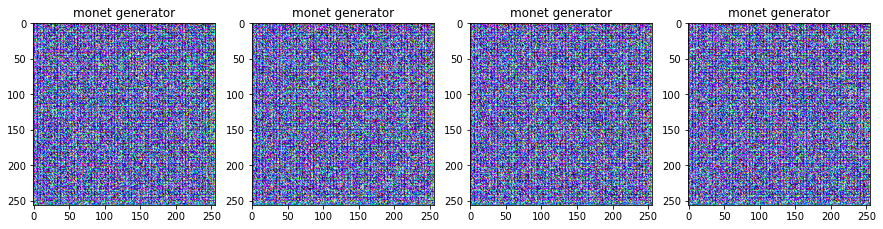

300it [02:46,  1.81it/s]


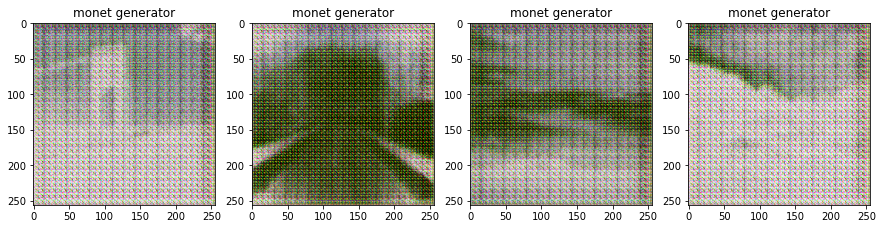

300it [02:45,  1.81it/s]


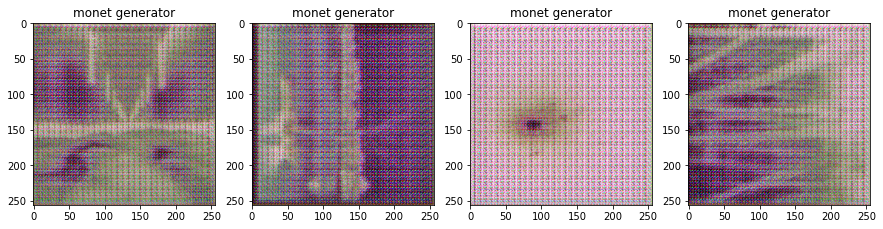

300it [02:46,  1.81it/s]


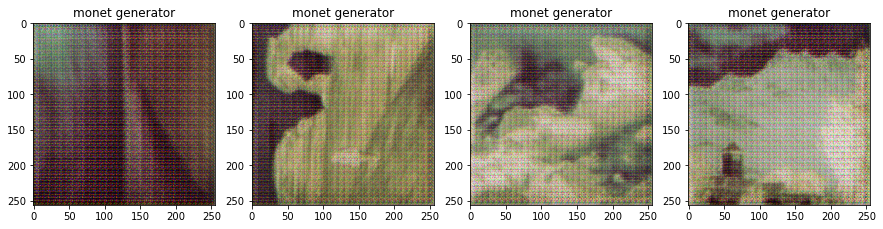

300it [02:46,  1.81it/s]


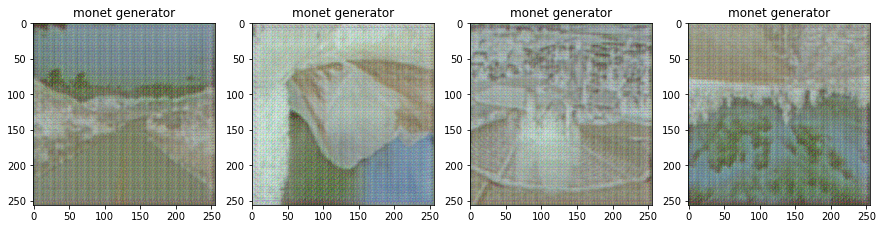

300it [02:45,  1.81it/s]


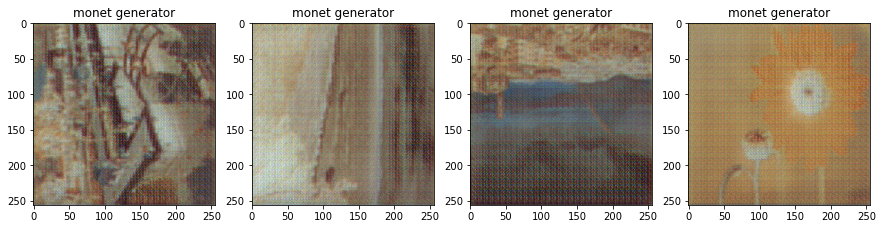

300it [02:45,  1.81it/s]


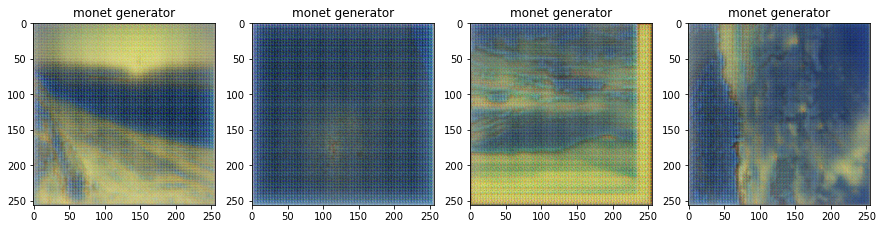

300it [02:46,  1.80it/s]


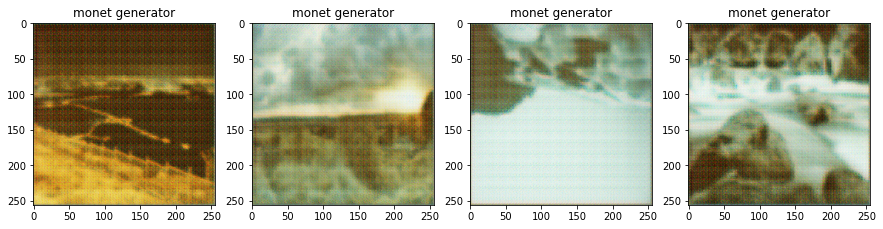

300it [02:46,  1.81it/s]


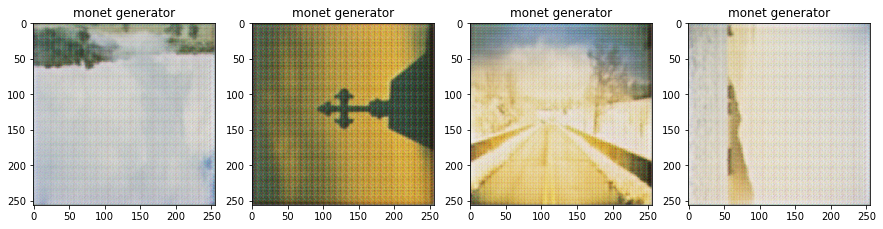

300it [02:46,  1.81it/s]


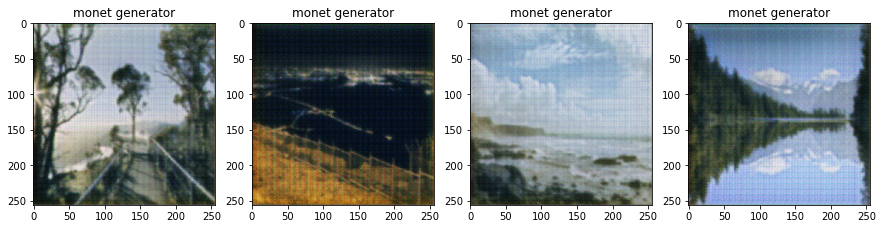

300it [02:46,  1.81it/s]


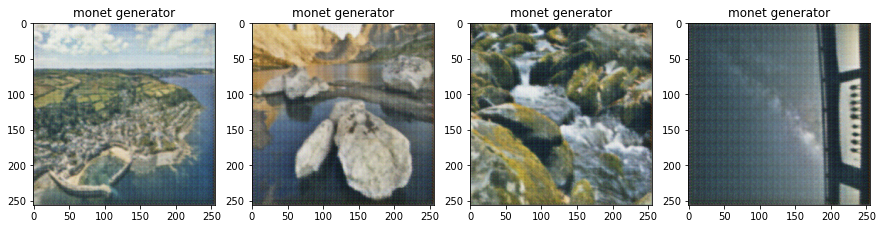

300it [02:45,  1.81it/s]


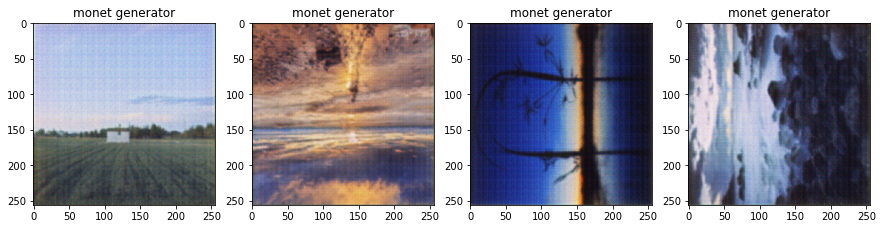

300it [02:46,  1.81it/s]


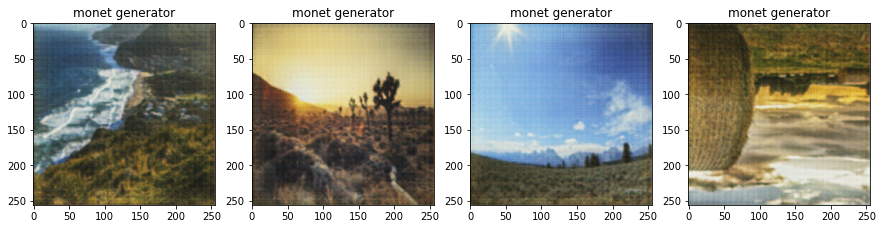

300it [02:45,  1.81it/s]


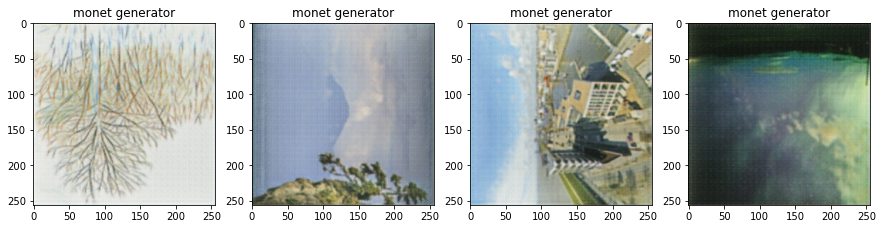

300it [02:46,  1.80it/s]


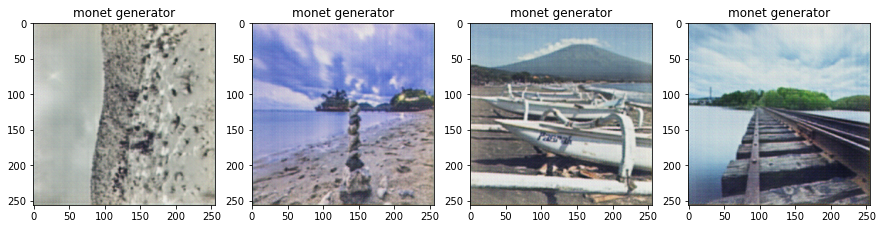

300it [02:44,  1.83it/s]


In [20]:
monet_iter = None
epochs = 16

fit(monet_ds, photo_ds, epochs)

In [22]:
if not(os.path.exists('images')):
    os.makedirs('images') # Create folder to save generated images

def predict_and_save(input_ds, generator_model):
    i = 1
    for img in tqdm(input_ds):
        prediction = generator_model(img, training=False) # make predition
        prediction = tf.cast((prediction * 127.5 + 127.5), tf.uint8)   # re-scale
        im = tf.squeeze(prediction, 0)
        im = im.numpy()
        im = Image.fromarray(im)
        im.save("images/" + str(i) + '.jpg')
        
        i += 1
        

In [23]:
batch_size = 1 # this is for the output only, taking an image one by one
photo_ds = get_ds(photo_imgs_fnames, aug = False)

predict_and_save(photo_ds, generator_monet)
    
    

7038it [02:23, 49.01it/s]


In [ ]:
import shutil
shutil.make_archive('/kaggle/working/images/', 'zip', 'images')
shutil.rmtree("./images")

### Summary and conclusion

This project shows the true power of GAN. The innovative use of CycleGAN to translate images from monet to photos and back is truly remarkable. I did not have  any for Hyperparameter turning because of the time taken but it was fascinating to learn how GANs can be used for unsupervised Deep Learning.
                                                                